# Прогнозирование оттока клиентов: неделя 1
*выполнил Юрий Исаков*

В рамках проекта мы будем решать задачу прогнозирования оттока пользователей, или churn prediction. Эта задача заключается в прогнозировании вероятности того, что клиент перестанет пользоваться сервисом в течение некоторого заданного заранее промежутка времени, например, решит перейти к конкуренту или откажется от использования услуги данного типа вообще.

Данные были предоставлены французской телекоммуникационной компанией Orange. В задаче речь идет о клиентских данных, поэтому данные были предварительно обфусцированы и анонимизированны: из датасета убрана любая персональная информация, позволяющая идентифицировать пользователей, а также не представлены названия и описания переменных, предназначенных для построения прогнозов. Мы будем работать с набором данных orange small dataset. Он состоит из 50 тыс. объектов и включает 230 переменных, из которых первые 190 переменных - числовые, и оставшиеся 40 переменные - категориальные.

In [1]:
# библиотеки, настройки
import pandas as pd
import numpy as np
import random

from statsmodels.stats.weightstats import *
from statsmodels.stats.proportion import proportion_confint

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

#### 1. Загрузите данные orange_small_churn_data.train и orange_small_churn_labels.train

In [2]:
data = pd.read_csv("data/orange_small_churn_data.train")
# labels = pd.read_csv("data/orange_small_churn_labels.train", header=None).ix[:,0].tolist()
labels = pd.read_csv("data/orange_small_churn_labels.train", header=None)

# имена категориальных и числовых переменных
features_num = data.columns[0:190]
features_cat = data.columns[190:230]

#### 2. Рассчитайте доли классов “отток” и “не отток”.
Мне удобнее работать с ноликами и единичками, поэтому я заменю все -1 на 0:

In [3]:
# labels = [0 if x == -1 else x for x in labels] # -1 --> 0
labels.columns = ["label"]
labels.loc[labels.label == -1, 'label'] = 0

print 'Доля класса "отток":', labels.label.mean()
print 'Доля класса "не отток":', 1 - labels.label.mean()

baseline = labels.label.mean()

data['label'] = labels.label # я не уверен, потребуется ли эта колонка потом, поэтому будет удалена

Доля класса "отток": 0.074275
Доля класса "не отток": 0.925725


#### 3. Рассчитайте корреляции переменных с целевой функцией и проанализируйте полученные данные.

Т.к. целевая переменная бинарная, то нам не подойдет расчет корреляции Пирсона (или любой другой), поэтому для числовых переменных посчитаем разность матожиданий переменных для обоих классов целевой переменной. Распределения числовых признаков могут быть самые разные (см. дальше), поэтому вместо меры похожести распределения признака по классам я буду пользоваться уровнем значимости гипотезы о том, что эти распределения совпадают. Для этого я воспользуюсь критерием Манна-Уитни.

In [4]:
# data.isnull().sum() # количество пропущенных значений

# print cor_numeric
diff_numeric = data.loc[data.label == 1, features_num].mean() - data.loc[data.label == 0, features_num].mean()

# проверим, значимо ли отличаются средние для обоих классов в каждом признаке
p_values = list()
for i, feat in enumerate(features_num):
    label0 = data.loc[data.label == 0, feat].dropna()
    label1 = data.loc[data.label == 1, feat].dropna()
    if len(label0) < 10 or len(label1) < 10:
        p_value = 1
    else:
        p_value = stats.mannwhitneyu(label0, label1)[1]
    p_values.append(p_value)

# сохраним разности матожиданий и значимости в отдельный датафрейм. и сразу отсортируем.
mns_and_ps = pd.DataFrame({'mean_diff': diff_numeric, 'p_value': p_values}).sort_values('p_value')

mns_and_ps.head()

,mean_diff,p_value
Var30,-3.375991,0.002470
Var84,-39.993175,0.011885
Var130,-0.310266,0.013911
Var161,2.096467,0.020109
Var176,-3.953740,0.025893


Мне не удалось рассчитать корреляции числовых признаков с целевой переменной ;(

Вместо корреляции
я буду пользоваться уровнем значимости гипотезы, что средние для обоих классов в данном признаке отличаются. Выше первые пять таких признаков.

#### 4. Визуализируйте данные: рассмотрите топ 20 числовых переменных, наиболее сильно коррелирующих с целевой функцией. Для этих переменных постройте распределения в разрезе классов. Отобразите объекты в координатах пар признаков

In [5]:
# выберем 20 признаков с наименьшими уровнями значимости
top20_num = mns_and_ps.index[:20].tolist()
mns_and_ps[:20]

,mean_diff,p_value
Var30,-3.375991,0.002470
Var84,-39.993175,0.011885
Var130,-0.310266,0.013911
Var161,2.096467,0.020109
Var176,-3.953740,0.025893
Var101,1.209453,0.026723
Var159,-2.250578,0.057181
Var87,-1.795242,0.059917
Var186,-1.935833,0.076288
Var114,-200143.641229,0.084768


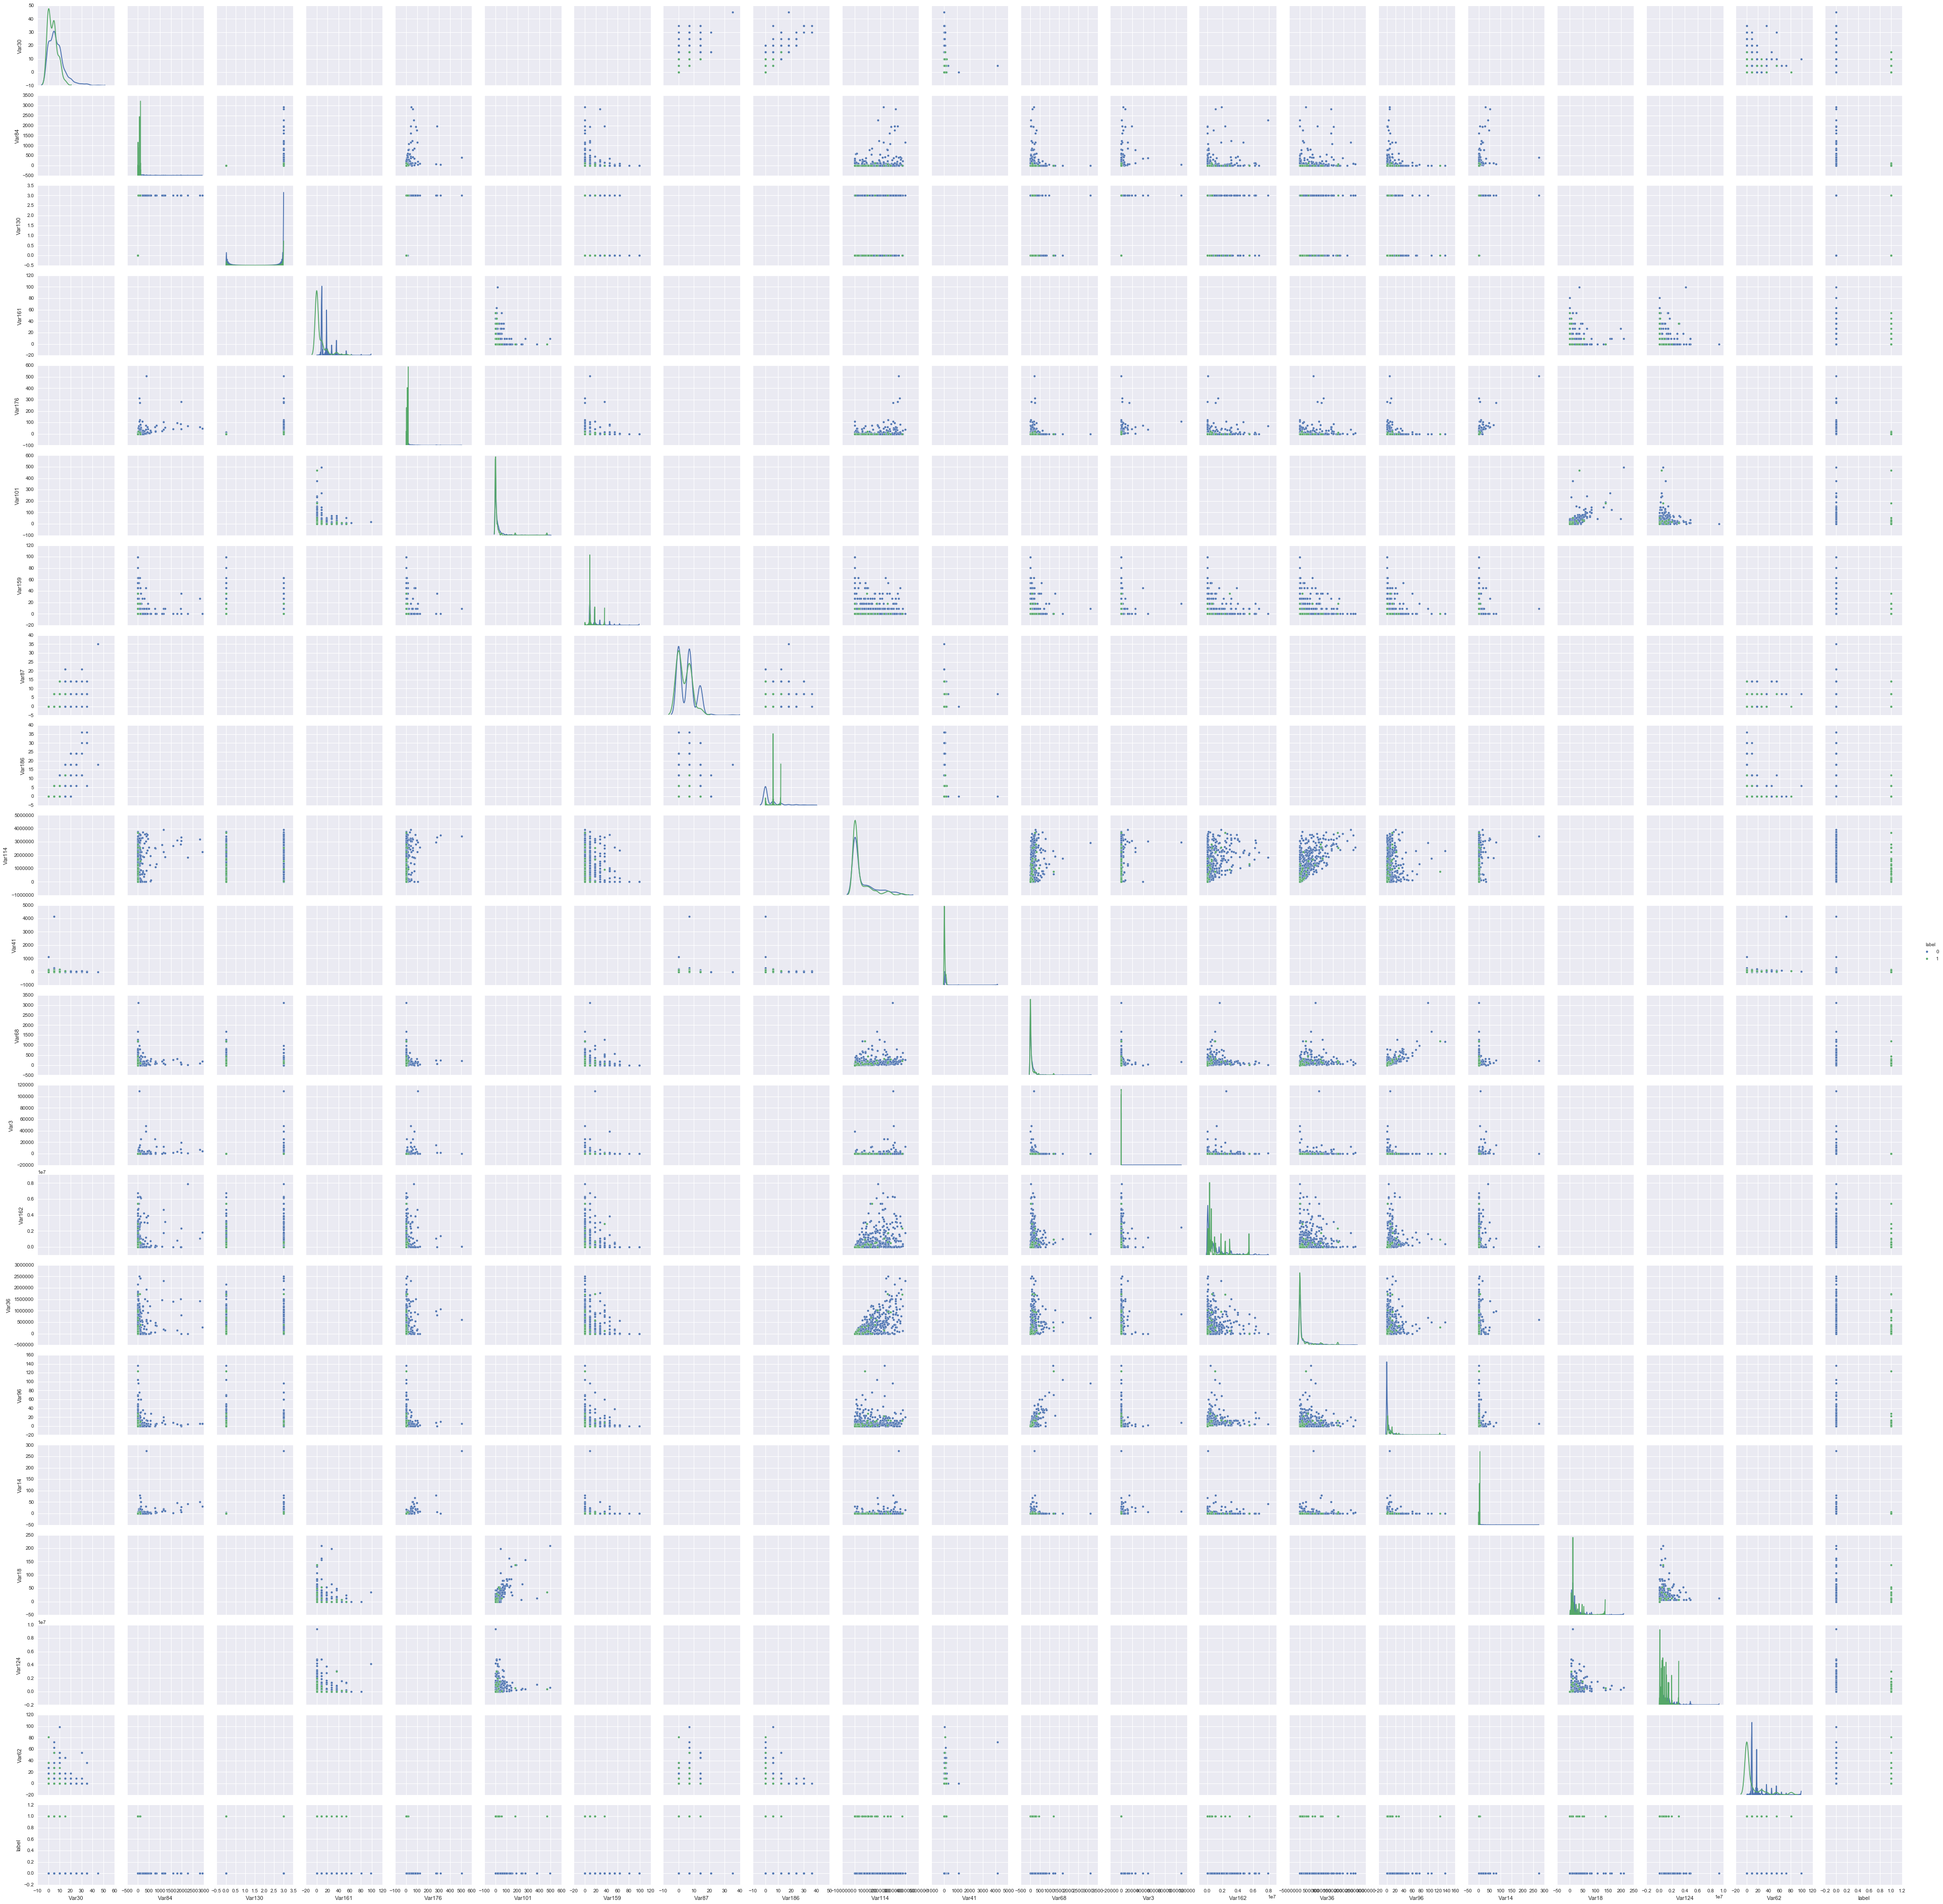

In [6]:
sns.pairplot(data[top20_num + ['label']], hue="label", diag_kind="kde")
plt.show()

Для большей наглядности можно посмотреть плотности распределения признаков в зависимости от класса не попарно, а отдельно:

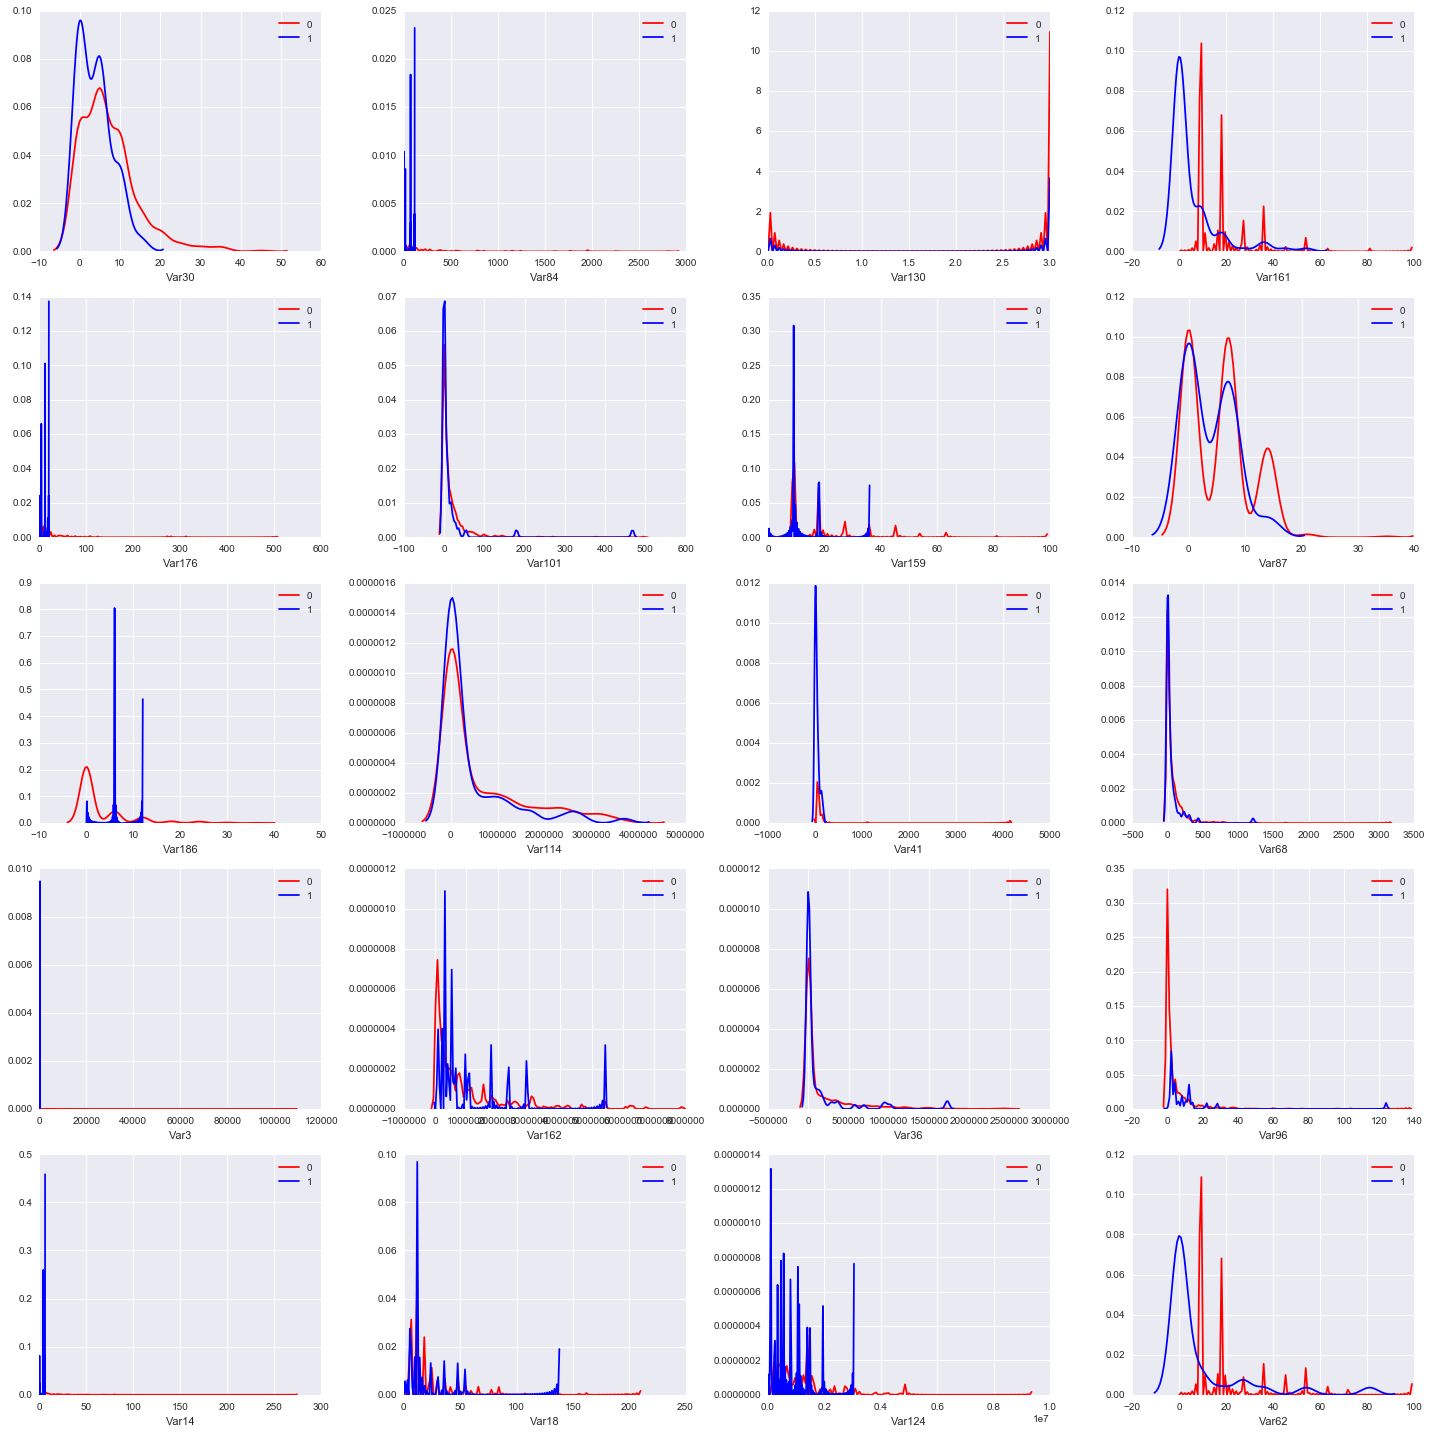

In [7]:
fig, axes = plt.subplots(5, 4, figsize=(20, 20))
for i in range(len(top20_num)):
    sns.kdeplot(data.loc[data.label == 0, top20_num[i]], color = 'r', ax=axes[i / 4, i % 4], label=0)
    sns.kdeplot(data.loc[data.label == 1, top20_num[i]], color = 'b', ax=axes[i / 4, i % 4], label=1)
    axes[i / 4, i % 4].set(xlabel=top20_num[i])
fig.tight_layout()

#### 5. Проделайте аналогичные шаги для случайно выбранных 10 числовых признаков.

In [8]:
# выберем 10 случайных числовых признаков
random.seed(19)

# предварительно выбросим признаки, у которых только пропущенные значения или данных очень мало
# (для этих признаков p_value была установлена 1)
random10_num = random.sample(mns_and_ps.index[mns_and_ps.p_value <1].tolist(), 10)
print random10_num

['Var106', 'Var182', 'Var90', 'Var2', 'Var156', 'Var147', 'Var1', 'Var19', 'Var171', 'Var104']


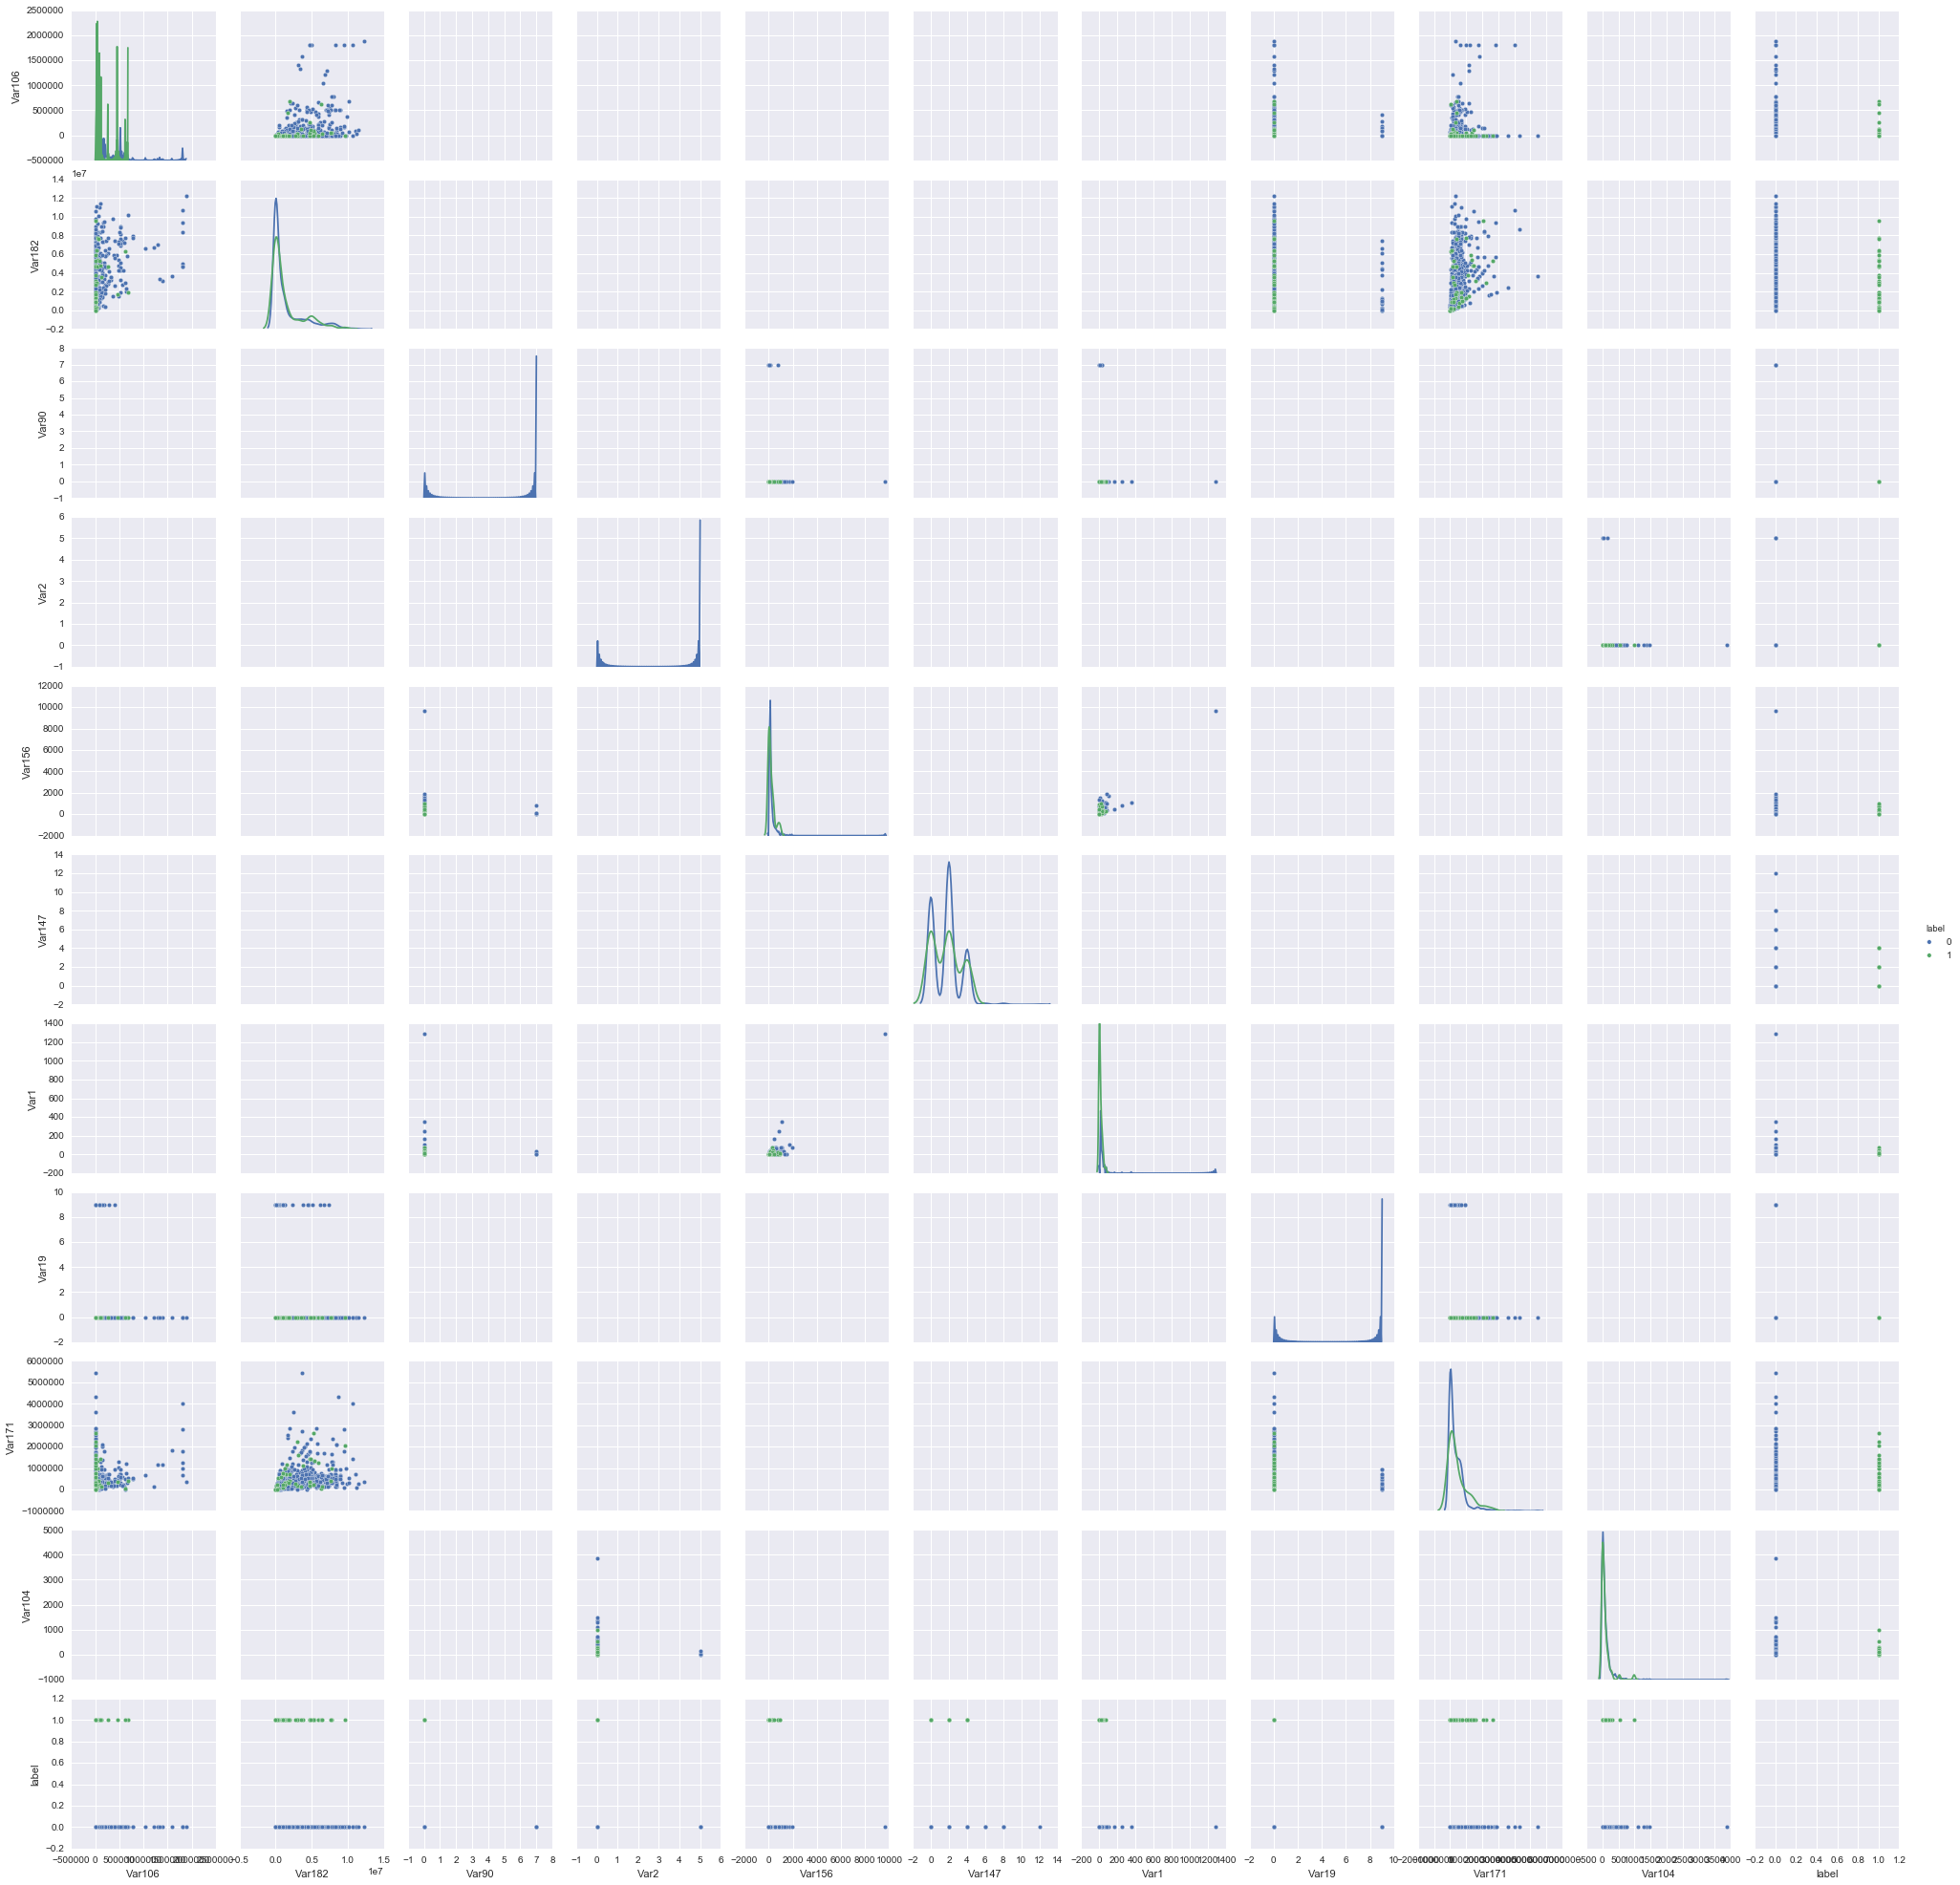

In [9]:
sns.pairplot(data[random10_num + ['label']], hue="label", diag_kind="kde")
plt.show()

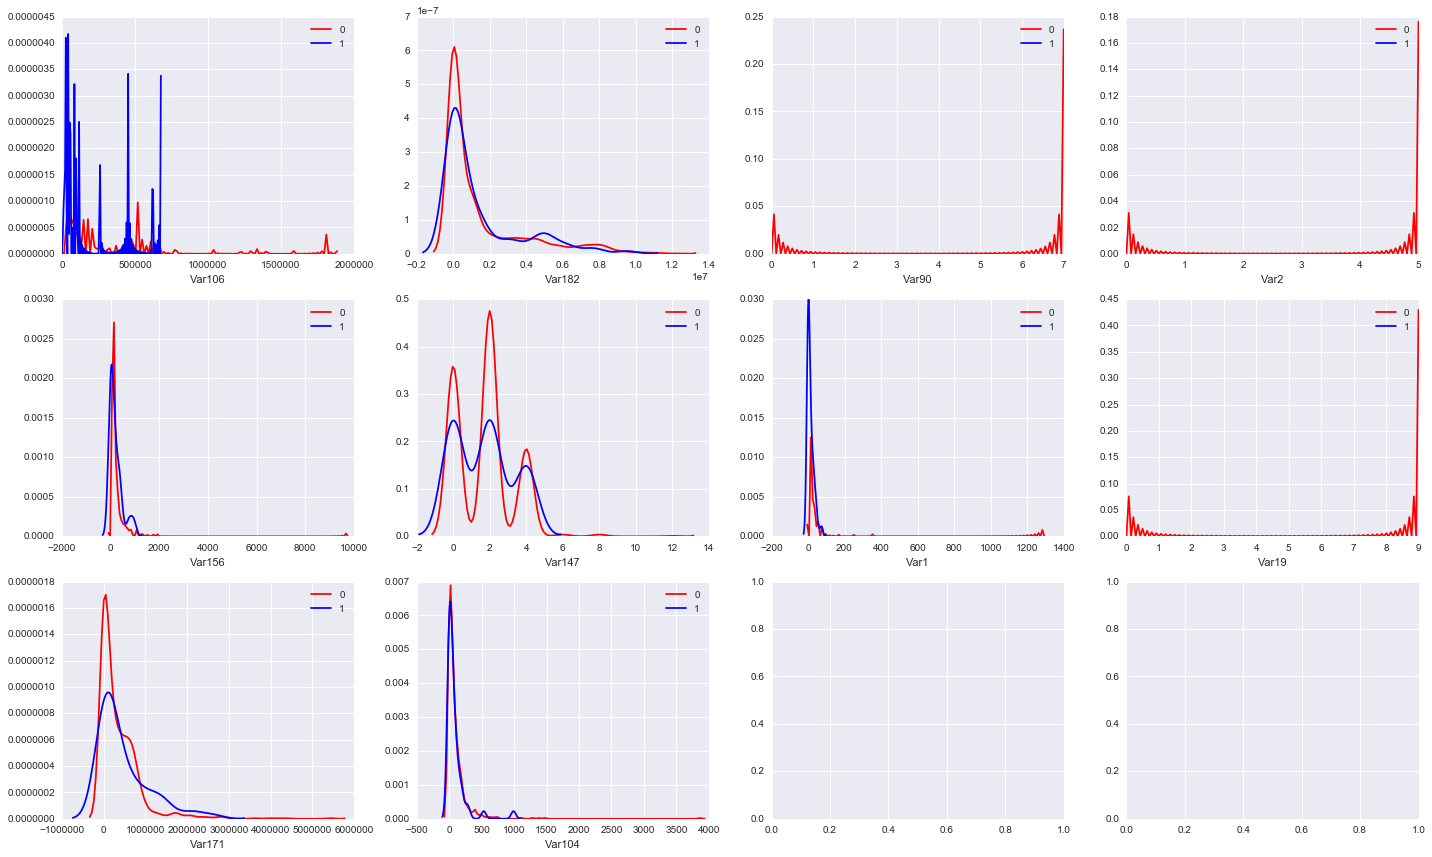

In [10]:
fig, axes = plt.subplots(3, 4, figsize=(20, 12))
for i in range(len(random10_num)):
    sns.kdeplot(data.loc[data.label == 0, random10_num[i]], color = 'r', ax=axes[i / 4, i % 4], label=0)
    sns.kdeplot(data.loc[data.label == 1, random10_num[i]], color = 'b', ax=axes[i / 4, i % 4], label=1)
    axes[i / 4, i % 4].set(xlabel=random10_num[i])
fig.tight_layout()

#### 6. Проделайте аналогичные шаги для 10 числовых признаков, наименее сильно коррелирующих с целевой переменной.

In [11]:
# выберем 10 признаков на наибольшими p_value (предварительно отбросив признаки у которых она равна 1)
last10_num = mns_and_ps[mns_and_ps.p_value <1][-10:].index.tolist()
print last10_num

['Var44', 'Var190', 'Var134', 'Var69', 'Var131', 'Var102', 'Var173', 'Var107', 'Var129', 'Var147']


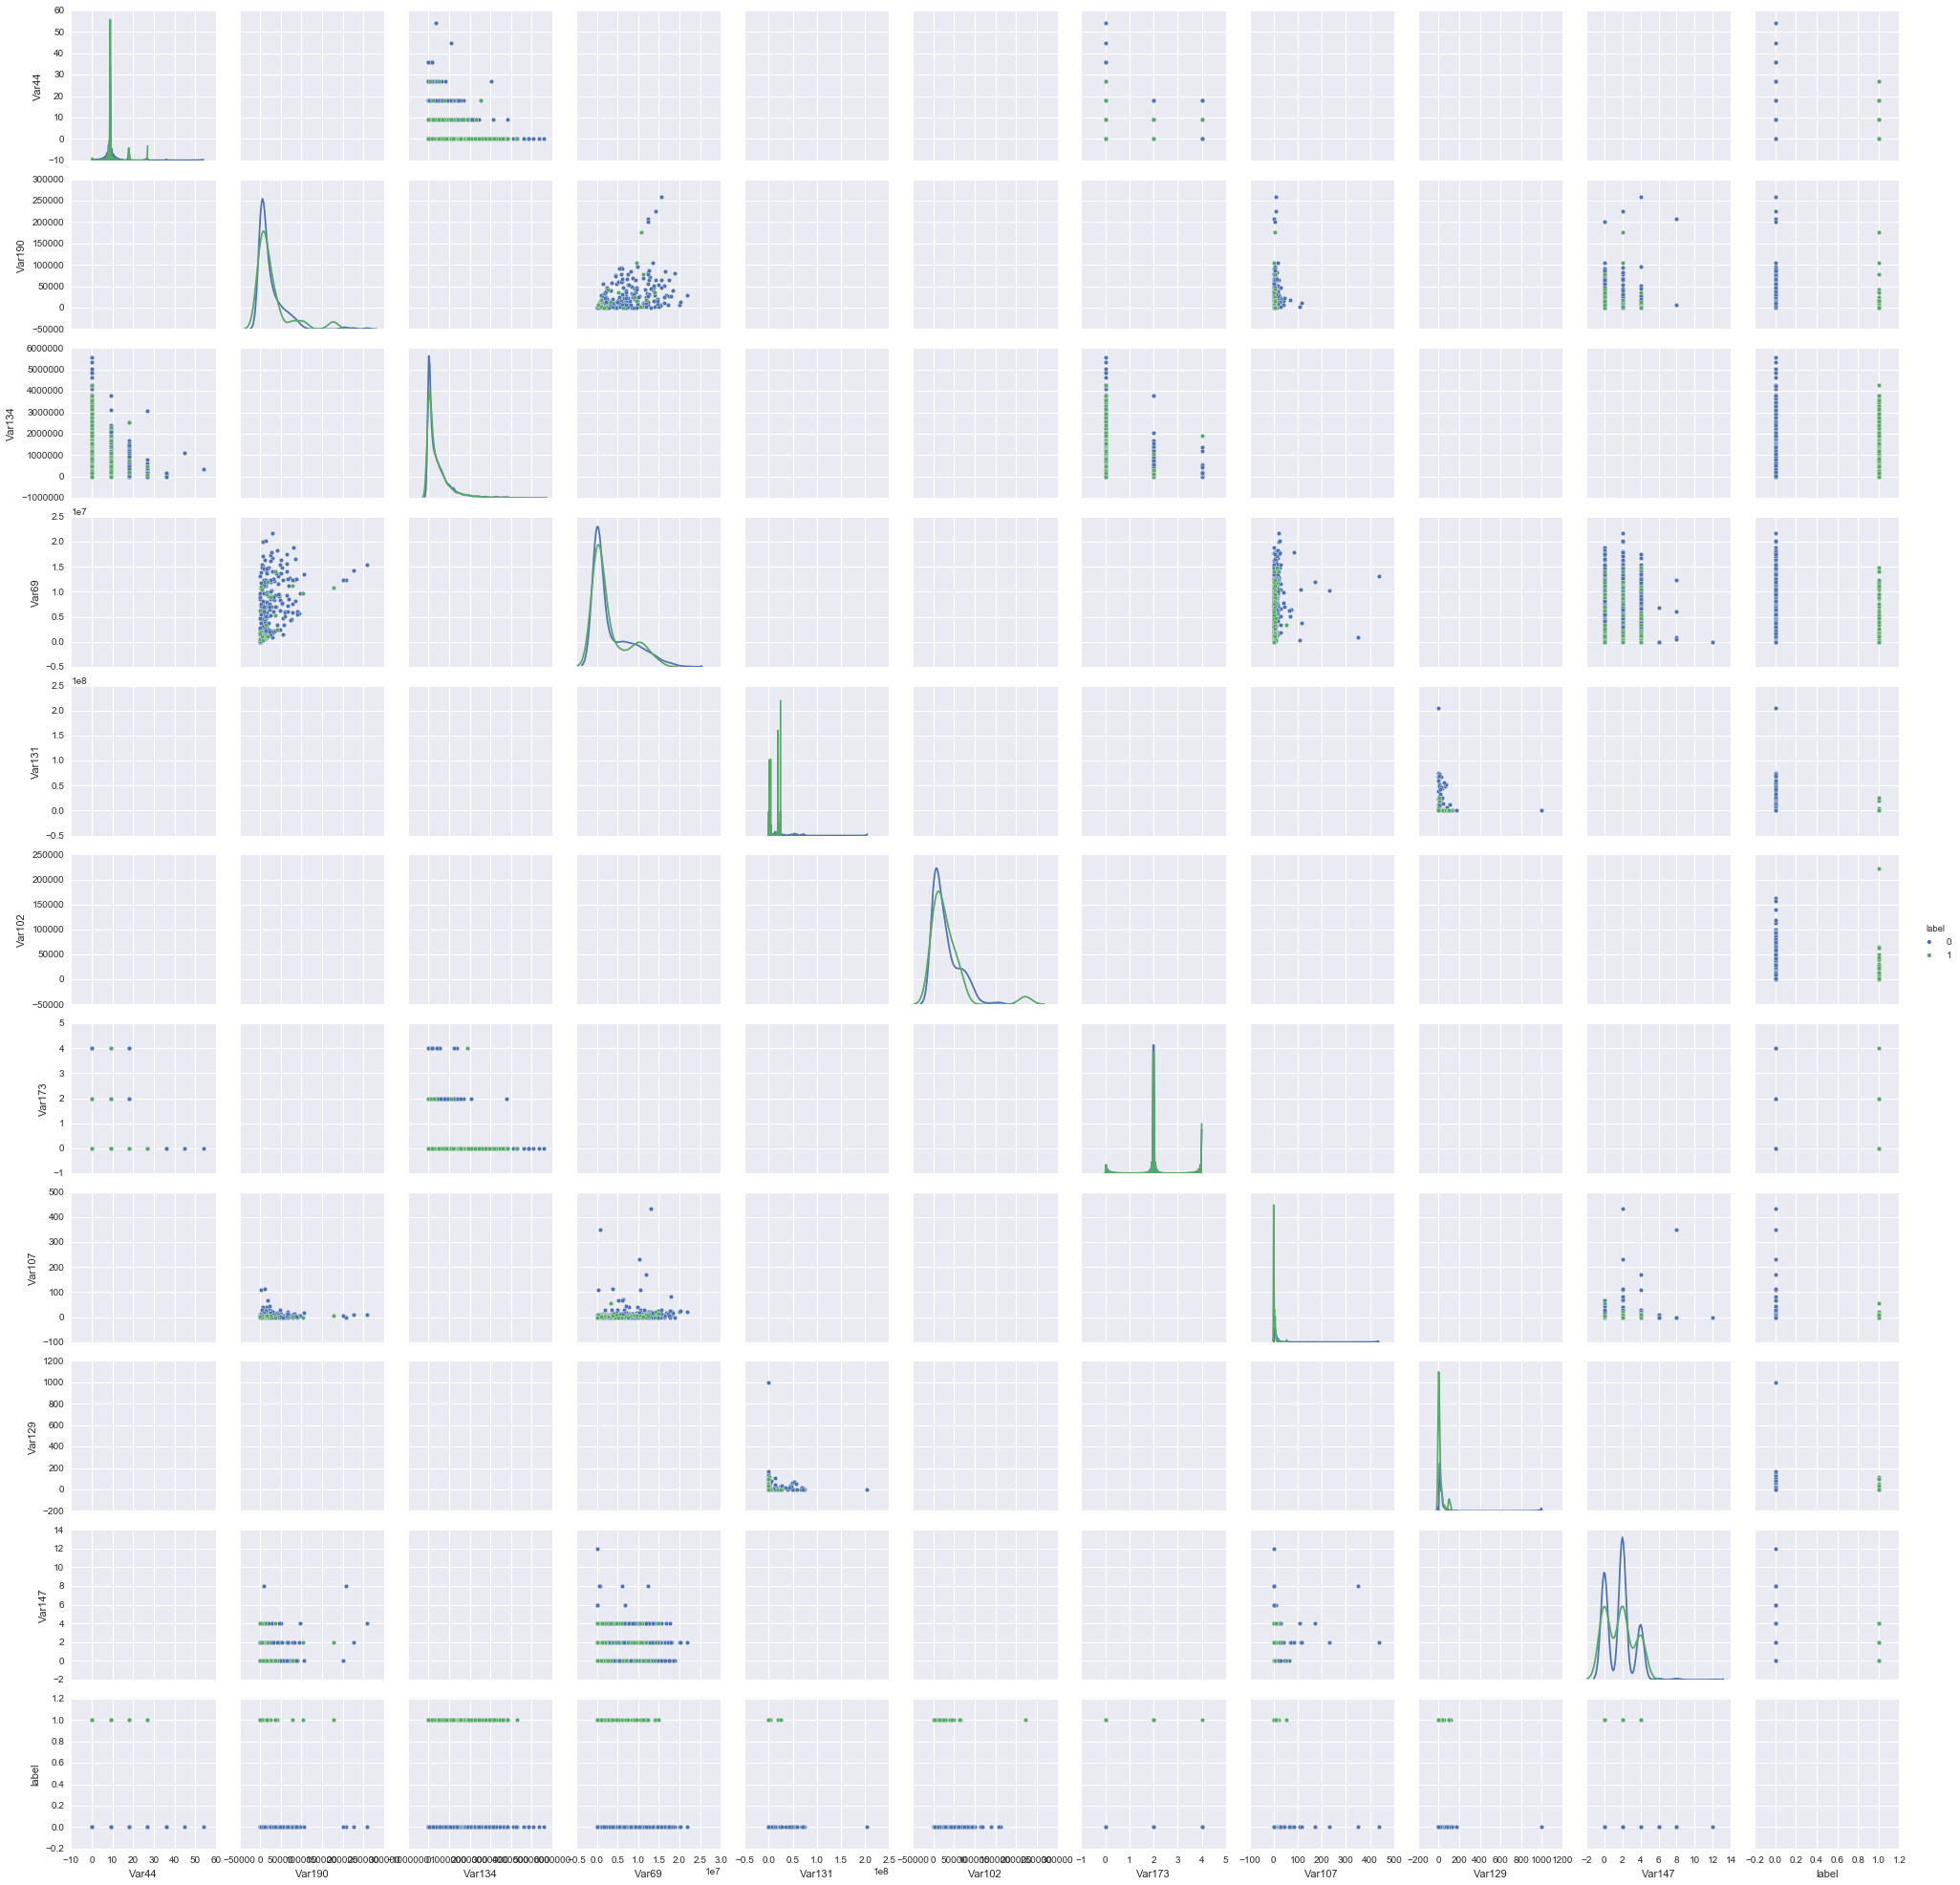

In [12]:
sns.pairplot(data[last10_num + ['label']], hue="label", diag_kind="kde")
plt.show()

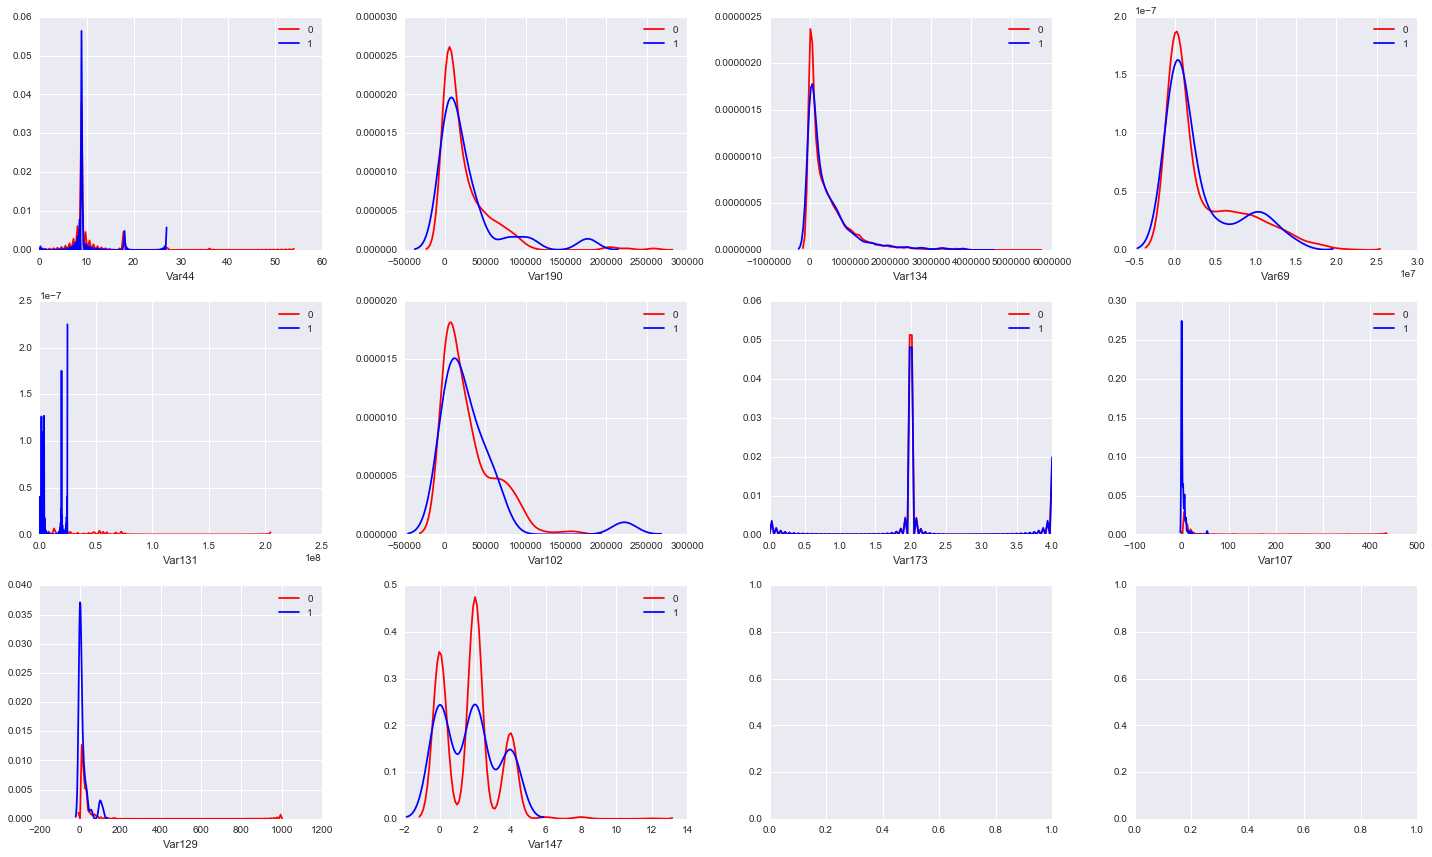

In [13]:
fig, axes = plt.subplots(3, 4, figsize=(20, 12))
for i in range(len(last10_num)):
    sns.kdeplot(data.loc[data.label == 0, last10_num[i]], color = 'r', ax=axes[i / 4, i % 4], label=0)
    sns.kdeplot(data.loc[data.label == 1, last10_num[i]], color = 'b', ax=axes[i / 4, i % 4], label=1)
    axes[i / 4, i % 4].set(xlabel=last10_num[i])
fig.tight_layout()

#### 7. Посмотрите на категориальные переменные: постройте и сравните гистограммы значений категориальных переменных для разных классов.

Некоторые признаки не имеют уникальных значений (т.е. единственное значение -- NaN), несколько признаков имеют только по одному уникальном значению. Выведем по 5 признаков с минимальным и максимальным числом уникальных значений:

In [14]:
# количество уникальных значений у каждого категориального признака
cat_counts = pd.Series([len(data[features_cat[i]].value_counts()) for i in range(40)], index = features_cat)

# вывод по 5 признаком с наименьшим и наибольшим количеством уникальных значений
print "5 признаков с наименьшим количеством уникальных значений:"
print cat_counts.sort_values()[:5]
print "5 признаков с наибольшим количеством уникальных значений:"
print cat_counts.sort_values()[-5:]

# исключим пустые признаки
features_cat = features_cat[data[features_cat].dtypes == "object"]

5 признаков с наименьшим количеством уникальных значений:
Var230    0
Var209    0
Var224    1
Var215    1
Var213    1
dtype: int64
5 признаков с наибольшим количеством уникальных значений:
Var199     4435
Var202     5524
Var217    12574
Var200    13369
Var214    13369
dtype: int64


Отобразим на столбиковой диаграмме количество выпавших значений для каждого класса. Рассмотрим только те признаки, где количество уникальных значений меньше 10 (которых оказалось 18 штук):

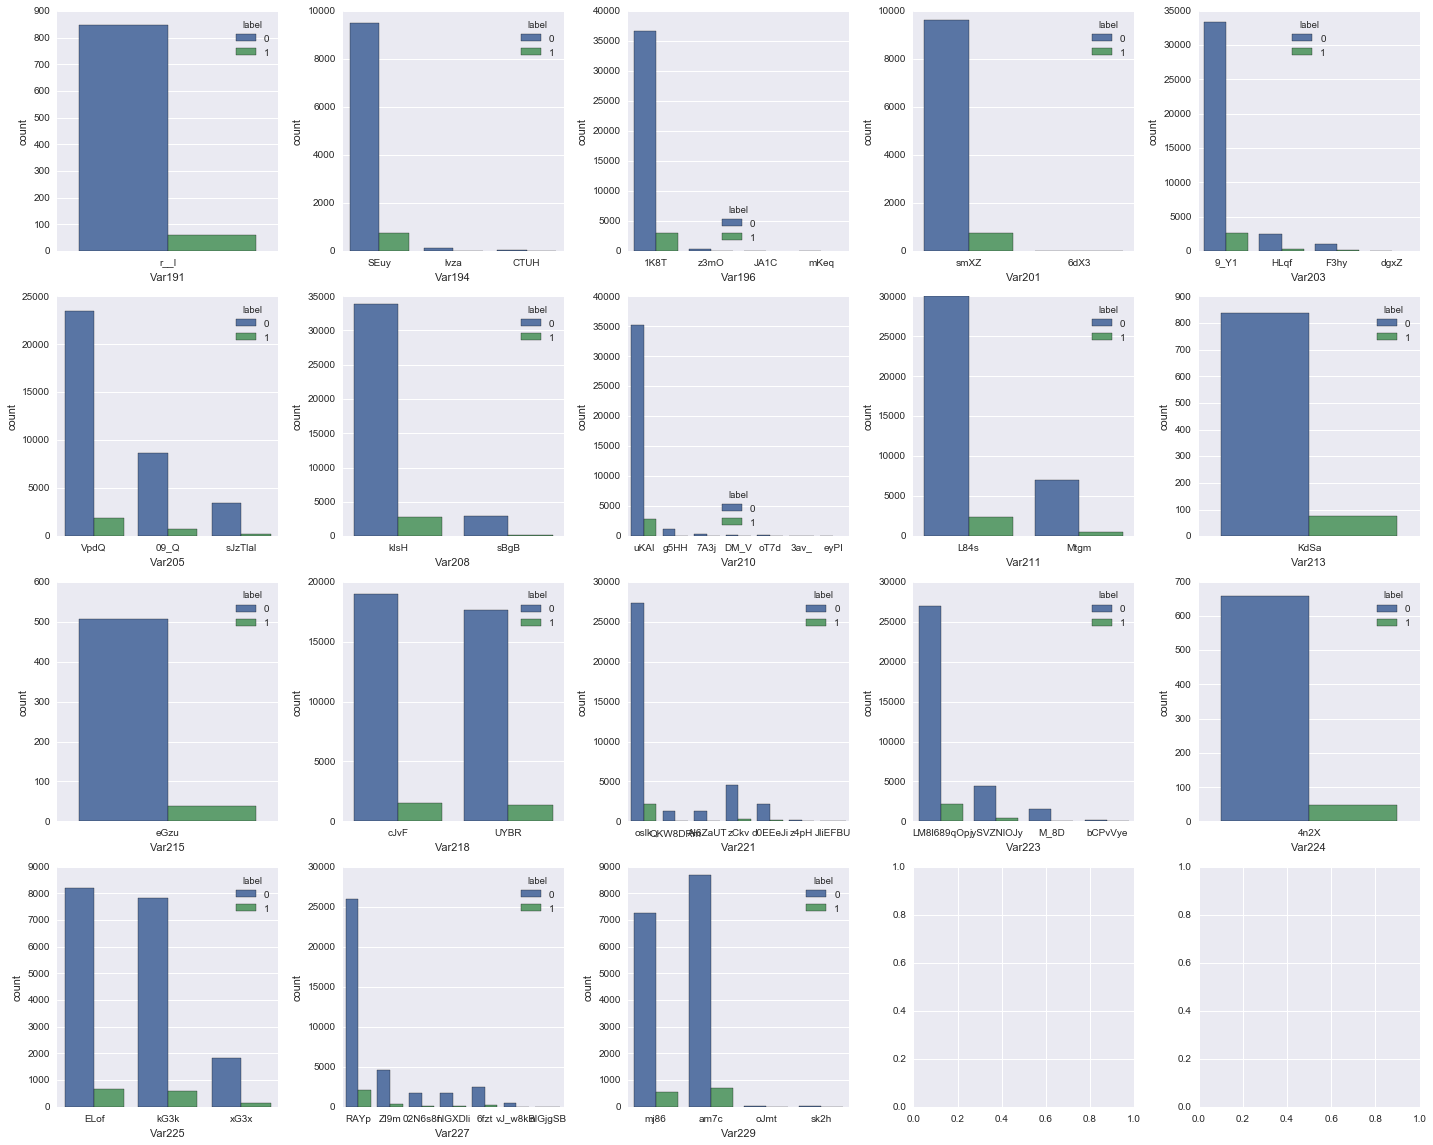

In [15]:
features = cat_counts[cat_counts.between(1, 10)].index
# print len(features) # =18

fig, axes = plt.subplots(4, 5, figsize=(20, 16))
for i, feat in enumerate(features):
    sns.countplot(x = feat, data = data, hue = 'label', ax=axes[i / 5, i % 5])
fig.tight_layout()

Помимо того, что при достаточно большом количестве уникальных значений в таких графиках ничего нельзя разглядеть, даже для уже построенных графиков трудно понять какие значения могут помочь в разделении классов, а какие нет. Здесь надо принять во внимание смещенность исходной выборки в сторону класса "не отток", доля которого почти 93%.

Можно отобразить не столбики для обоих классов, а долю положительного класса, соответствующую каждому уникальному значению (для красоты, представлены только признаки, у которых не больше 20 уникальных значений). Чтобы можно было сравнить визуально, на каждом графике отобразим горизонтальную линию общей доли положительного класса по всей выборке:

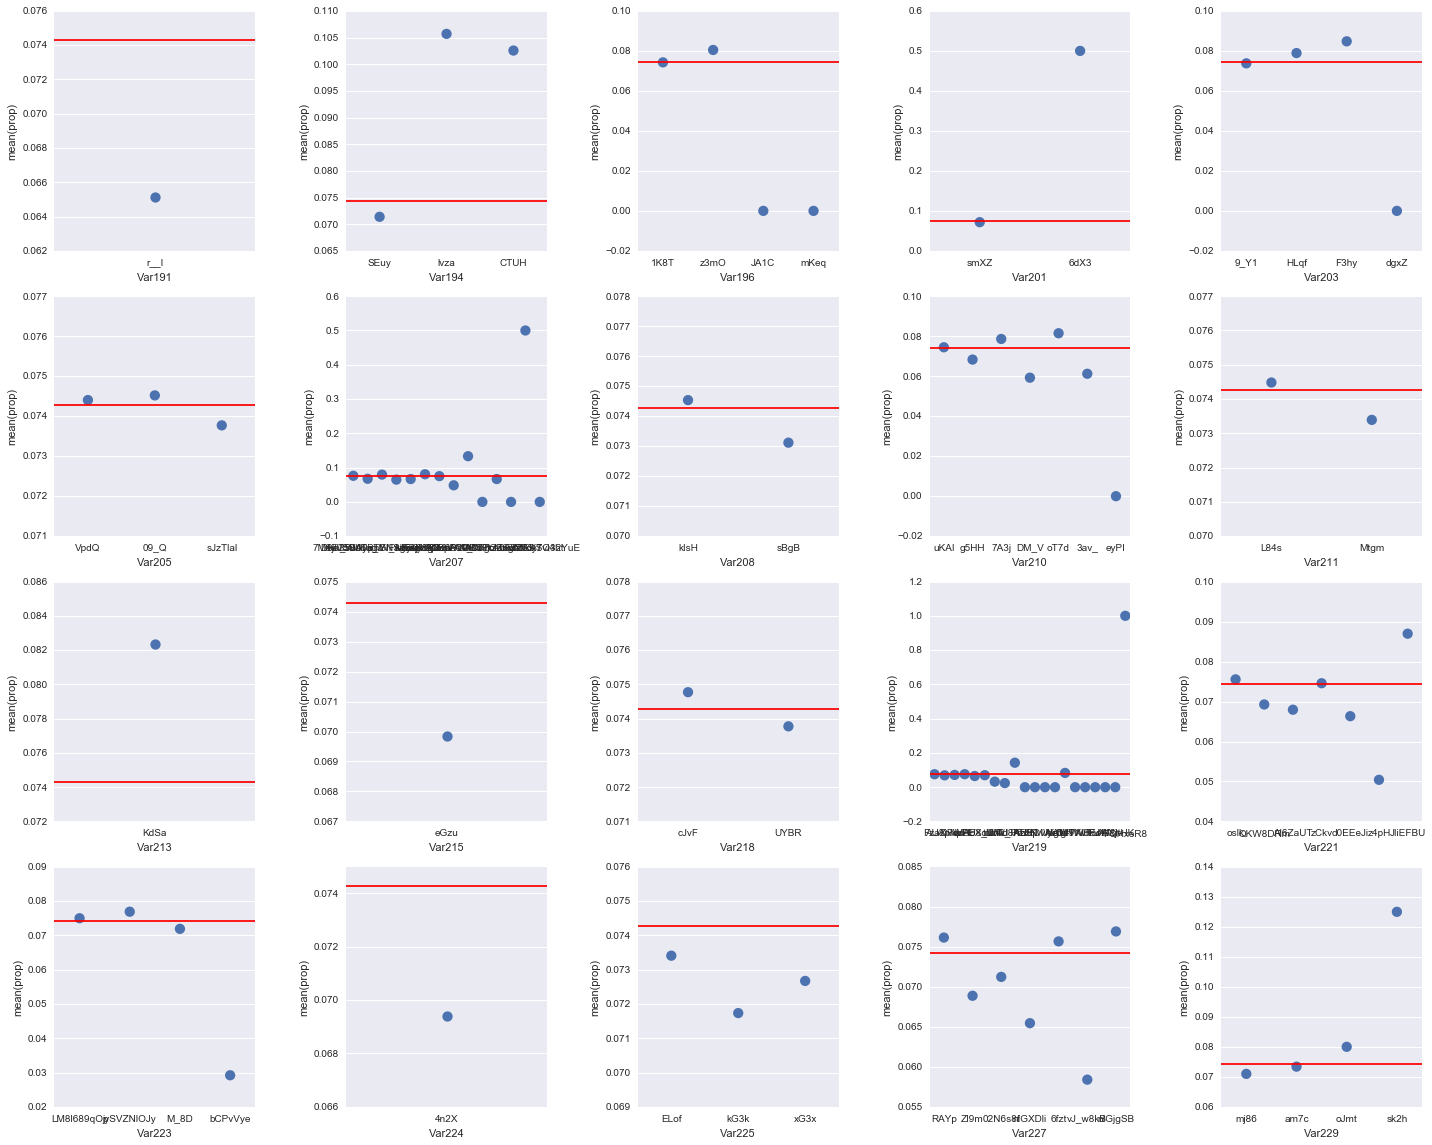

In [16]:
# отобразим признаки, у которых до 20 уникальных значений
features = cat_counts[cat_counts.between(1, 20)].index
# print len(features) # 20 штук

fig, axes = plt.subplots(4, 5, figsize=(20, 16))
for i, feat in enumerate(features):
    # готовим минидатафрейм с инфой по значениям
    values = list(data[feat].unique())
    props = list()
    for val in values:
        props.append( np.mean(data.loc[data[feat] == val, 'label']) )
    featured_df = pd.DataFrame({'value': values, 'prop': props})
    
    # график
    ax_cur = axes[i / 5, i % 5]
    sns.pointplot(x="value", y="prop", join=False, data=featured_df, ax=ax_cur) # точки
    ax_cur.axhline(y=baseline, color='r') # горизонтальная линия
    ax_cur.set(xlabel=feat) # подпись признака
    
fig.tight_layout()

Кажется неясным, насколько сильно точка должна отклоняться от горизонтальной линии, чтобы признак оказался полезным. Далее я попробую для каждого признака и его уникальных значений посчитать доверительный интервал доли. Если он будет включать долю положительного класса по всей выборке (бейслайн), то не буду считать этот признако полезным или наоборот.

In [17]:
# строим доверительный интервал Вильсона (т.к. смещенные доли) и проверяем, принадлежит ли ему бейслайн
def in_conf_int(baseline, proportion, n, alpha = 0.05):
    conf_int = proportion_confint(proportion*n, n, alpha = alpha, method="wilson")
    # print baseline, conf_int
    if baseline > conf_int[0] and baseline < conf_int[1]:
        return True
    return False

Например, посмотрим на первые 5 значений для признака Var212. Возможно, пропущенное значение (nan) окажется полезным, поэтому переведем его в строку (fakenan) и будем работать как с отдельным значением:

In [18]:
# дадим шанс пропущенным значениям
data[features_cat] = data[features_cat].fillna('fakenan')

feat = 'Var212'
values = list(data[feat].unique())
props = list()
print "feature: " + feat
for val in values[:5]:
    sub_label = data.loc[data[feat] == val, 'label'] # целевая переменная только у выбранного значения
    conf_int = proportion_confint(np.mean(sub_label)*len(sub_label), len(sub_label), method="wilson")
    print "value: {0:12}".format(val) + "\tn: {0:6}".format(len(sub_label)) +\
        "\tprop: {0:.4f}".format(np.mean(sub_label)) +\
        "\t CI: [{0:.4f}, {1:.4f}]".format(conf_int[0], conf_int[1]) +\
        "\tbaseline in CI: {0}".format(in_conf_int(baseline, np.mean(sub_label), len(sub_label)))

feature: Var212
value: NhsEn4L     	n:  23390	prop: 0.0767	 CI: [0.0734, 0.0802]	baseline in CI: True
value: XfqtO3UdzaXh_	n:   5137	prop: 0.0749	 CI: [0.0681, 0.0825]	baseline in CI: True
value: a3CcPDe     	n:    120	prop: 0.0917	 CI: [0.0520, 0.1567]	baseline in CI: True
value: h0lfDKh52u4GP	n:    611	prop: 0.0458	 CI: [0.0319, 0.0654]	baseline in CI: False
value: UbxQ8lZ     	n:    433	prop: 0.0785	 CI: [0.0567, 0.1077]	baseline in CI: True


Видно, что для одного из значений, которое встречается 611 раз доверительный интервал (CI) не включает бейслайн, поэтому можно надеяться, что этот признак окажется полезным. Пройдемся по всем признакам и найдем те из них, которые включают такие значения, в доверительных интервал которых доля не входит:

In [19]:
# дадим шанс пропущенным значениям
# data[features_cat] = data[features_cat].fillna('fakenan')

# фичи со значимыми различиями записываем в множество
features_cat_sign = set()
# перебор по всем категориальным признакам
for feat in features_cat:
    values = data[feat].unique()
    for val in values:
        sub_label = data.loc[data[feat] == val, 'label'] # целевая переменная только у выбранного значения
        if not in_conf_int(baseline, np.mean(sub_label), len(sub_label)):
            features_cat_sign.add(feat) # добавляем переменную в множество, если доля не в интервале

# вывод признаков
print features_cat_sign

set(['Var226', 'Var223', 'Var222', 'Var220', 'Var228', 'Var208', 'Var204', 'Var207', 'Var206', 'Var201', 'Var200', 'Var203', 'Var202', 'Var197', 'Var199', 'Var198', 'Var219', 'Var216', 'Var217', 'Var214', 'Var212', 'Var193', 'Var192'])


#### 8. Проанализируйте полученные результаты:

- Какие выводы вы можете сделать? Заметили ли вы какие-нибудь интересные закономерности?

- На основании полученных изображений и таблиц, предположите, какие переменные окажут наибольшее влияние (вклад) в модель?

- Какие переменные на ваш взгляд окажутся наименее полезными, шумовыми?

- Как вы думаете, окажется ли отбор признаков полезным для построения модели?

В целом, визуальный анализ повторяет статистический для числовых признаков. Графики фич с низкими p_value сильнее отличаются, чем для тех, у которых они высокие. Для категориальных переменных такого сказать нельзя, потому как важность зависит не только от доли, но и от количества значений признака. Так, с ростом количиства для каждого значения растет уверенность, насколько сильно доля отличается от бейслайна.

На основании изображений и таблиц, я выберу из числовых признаков те, у которых p_value критерия Манна-Уитни для обоих классов меньше 10%, а из категориальных - те, бейслайн которых не входит в 95% доверительный интервал хотя бы для одного из значений:

In [20]:
print "Числовые признаки: ", mns_and_ps[mns_and_ps.p_value < 0.1].index.tolist()
print "Числовые признаки: ", list(features_cat_sign)

Числовые признаки:  ['Var30', 'Var84', 'Var130', 'Var161', 'Var176', 'Var101', 'Var159', 'Var87', 'Var186', 'Var114', 'Var41']
Числовые признаки:  ['Var226', 'Var223', 'Var222', 'Var220', 'Var228', 'Var208', 'Var204', 'Var207', 'Var206', 'Var201', 'Var200', 'Var203', 'Var202', 'Var197', 'Var199', 'Var198', 'Var219', 'Var216', 'Var217', 'Var214', 'Var212', 'Var193', 'Var192']


Наименее полезными кажутся признаки состоящии исключительно из пропущенных значений. Также, видятся малополезными те числовые, у которых p_value очень высокий и категориальные, у которых для всех значений доля положительного класса мало оличается от средней по всей выборке.

Я думаю, что отбор признаков окажется полезным для построения модели.